# 5. Deep Learning for Computer Vision

## Using a Pretrained Convnet

In [1]:
import os

from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

A highly effective approach to deep learining on small image datasets is to use a <b>pretrained network</b>. A pretrained network is a saved network that was previously trained on a large dataset, typically on a large scale image classification task. If this original dataset is large enough and general enough then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic mdoel of the visual world, and hence its features can prove useful for many different compute vision problems, even though these new problems may involve completely different classes than those of the original task.

We will use VGG16 architecture, which is a simple and widely used convnet architecture for ImageNet. Although it is an older model, far from the current state of the art and somewhat heavier than many other recent mocels, its architecture is similar to what we have learnt before and is easy to understand.

To use a pretrained network there are two ways: <b>feature extraction</b> and <b>fine-tuning</b>.

### Feature Extraction

Feature extraction consists using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification has two parts: 
- A series of pooling and convolution layers (the <b>convolutional base</b>)
- A densely connected classifier

In the case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifer on top of the output.

<img src="img5h.png" width="575"/>

Generally, we reuse the convolutional base as the representations learnt by the convlutional base are likely to be more generic and therefore more reusable. The feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. In contrast, the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained - they will only contain information about whether this or that class exists in the entire picture.

For this example, we will use the convolutional base of the VGG16 network, trained on ImageNet to extract interesting features from cat and dog images, and then train a dog-vs-cat classifier on top of these features.

In [2]:
# Instantiate Model
conv_base = keras.applications.VGG16(
    # specifies the weight checkpoint from which to initialise the model
    weights='imagenet', 
    # refers to use/not use the densly connected classifier (which we are not)
    include_top=False, 
    # shape of the image tensors to be fed into the network
    input_shape=(150,150,3) )

You can see that the architecture of the VGG16 convolutional base is similar to the convnets we have seen before:

In [3]:
# For testing
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

From here, there are two ways to proceed:

1. Run the convolutional base over the dataset, recording the output to a Numpy array, then use this data to input to a standalone, densly connected classifier.

2. Extend the `conv_base` by adding `Dense` layers on top, and running the whole thing end to end on the input data.

<b>Method 1</b>

In [4]:
# Preprocessing
HOME_DIR = os.path.dirname(os.path.abspath('__FILE__'))
WORKSPACE_DIR = os.path.join(HOME_DIR, 'workspace')

train_dir = os.path.join(WORKSPACE_DIR, 'train')
validation_dir = os.path.join(WORKSPACE_DIR, 'validation')
test_dir = os.path.join(WORKSPACE_DIR, 'test')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Here we load the datasets onto Numpy arrays.

In [5]:
def extract_features(directory, sample_count):
    
    BATCH_SIZE = 20
    TARGET_SIZE = (150, 150)
    CLASS_MODE = 'binary'
    features = np.zeros(shape=(sample_count, 4,4,512))
    labels = np.zeros(shape=(sample_count))
    
    datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(directory, target_size=TARGET_SIZE,
                                           batch_size=BATCH_SIZE, class_mode=CLASS_MODE)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = features_batch
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = labels_batch
        i+=1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

In [25]:
import warnings
warnings.filterwarnings("ignore")

train_features, train_labels = extract_features(train_dir, 2000)
train_features = np.reshape(train_features, (2000, 4*4*512))

val_features, val_labels = extract_features(train_dir, 1000)
val_features = np.reshape(val_features, (1000, 4*4*512))

Found 2000 images belonging to 2 classes.


/Users/bryanlim/.pyenv/versions/3.7.2/envs/botanic/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/Users/bryanlim/.pyenv/versions/3.7.2/envs/botanic/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/Users/bryanlim/.pyenv/versions/3.7.2/envs/botanic/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/Users/bryanlim/.pyenv/versions/3.7.2/envs/botanic/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size,

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Now that the data images have been transformed, we can use it to train the densely connected layer model directly.

In [27]:
model21a = keras.models.Sequential()
model21a.add(keras.layers.Dense(256, activation='relu', input_dim=4*4*512))
model21a.add(keras.layers.Dropout(0.5))
model21a.add(keras.layers.Dense(1, activation='sigmoid'))
print(model21a.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
model21a.compile(optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), 
              loss='binary_crossentropy', metrics=['accuracy'])
history21a = model21a.fit(train_features, train_labels, epochs=50, batch_size=20,
         validation_data=(val_features, val_labels), verbose=0)

Epoch 1/50
100/100 [==============================] - 4s 42ms/step - loss: 0.6057 - accuracy: 0.6700 - val_loss: 0.4494 - val_accuracy: 0.8190
Epoch 2/50
100/100 [==============================] - 4s 41ms/step - loss: 0.4408 - accuracy: 0.8095 - val_loss: 0.3597 - val_accuracy: 0.8680
Epoch 3/50
100/100 [==============================] - 4s 40ms/step - loss: 0.3634 - accuracy: 0.8485 - val_loss: 0.3168 - val_accuracy: 0.8820
Epoch 4/50
100/100 [==============================] - 4s 44ms/step - loss: 0.3215 - accuracy: 0.8685 - val_loss: 0.2811 - val_accuracy: 0.9000
Epoch 5/50
100/100 [==============================] - 4s 44ms/step - loss: 0.3065 - accuracy: 0.8765 - val_loss: 0.2634 - val_accuracy: 0.9030
Epoch 6/50
100/100 [==============================] - 5s 47ms/step - loss: 0.2753 - accuracy: 0.9005 - val_loss: 0.2454 - val_accuracy: 0.9050
Epoch 7/50
100/100 [==============================] - 5s 47ms/step - loss: 0.2554 - accuracy: 0.8945 - val_loss: 0.2344 - val_accuracy: 0.9110

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.054232,0.9875,0.046295,0.991,46
46,0.047314,0.9930,0.043953,0.991,47
47,0.047697,0.9905,0.039666,0.994,48
48,0.047004,0.9925,0.038363,0.994,49
49,0.043207,0.9940,0.036615,0.994,50


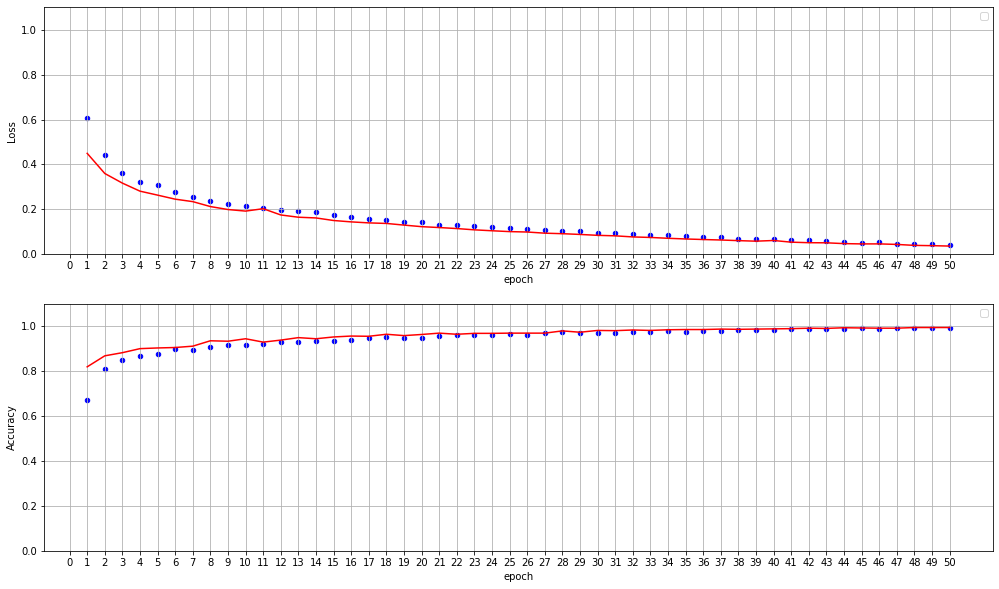

In [35]:
import warnings
warnings.filterwarnings("ignore")

metrics_df = pd.DataFrame(history21a.history)
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,10))
ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,1.1)
ax1.set_xticks(range(0,51))

metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red',)
ax2.set_ylabel("Accuracy")
ax2.grid('GAINSBORO')
ax2.set_xticks(range(0,51))
ax2.legend([])
ax2.set_ylim(0,1.1)
plt.show()

The following is method 2. This allows us to use data augmentation during training. Extend the `conv_base` and running it end to end on the inputs.

<p style="color:maroon"><b>NOTE: This cannot be done without a GPU. Refer to Colab notebook for implementation details.</b></p>

### Fine-Tuning

Another widely used technique for model reuse, complementary to feature extraction is <b>fine-tuning</b>. Fine-tuning consists of freezing the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model and these top layers.

This is called fine tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more applicable to the problem at hand.

<img src="img5i.png" width="450"/>

<p style="color:maroon"><b>NOTE: This cannot be done without a GPU. Refer to Colab notebook for implementation details.</b></p>

Wrapping up, there are some key takeaways:

1. Convnets are the best type of ML models for computer vision problems. It is possible to train one from scratech even on a small dataset.
2. On a small dataset, overfitting will be the main issue. Data Augmentation is a powerful way to fight overfitting.
3. We can use a pretrained convnet on a new dataset. We can use this for both feature extraction and fine-tuning. Feature extraction is to learn spatial hierarchy before performing the task, while fine-tuning is to train the last layers in the convolutional base before doing the task in the Dense layer.